Kelompok 6 :
- Muhammad Rafie Al Habsyi
- Arya Aydin Margono
- Boy Aditya Rohmaulana
- Raffi Ardhi Naufal

### Task Analisis Sentimen Ulasan Salah Satu Produk di Aplikasi Shopee

Pada tugas kali ini, penulis melakukan analisis sentimen pada produk smart watch yang bisa dilihat secara langsung dengan menekan link berikut : https://shopee.co.id/Rubber-Strap-20mm-with-Black-Buckle-for-Smartwatch-Amazfit-GTS-GTS-2-GTS-2-Mini-GTS-4-Mini-GTS-2e-BIP-BIP-Lite-BIP-S-BIP-U-BIP-U-Pro-BIP-3-BIP-3-Pro-GTR-42mm-i.134788402.20445175342?sp_atk=48ae98b3-89a4-46ed-a064-9da7a1d6c453&xptdk=48ae98b3-89a4-46ed-a064-9da7a1d6c453

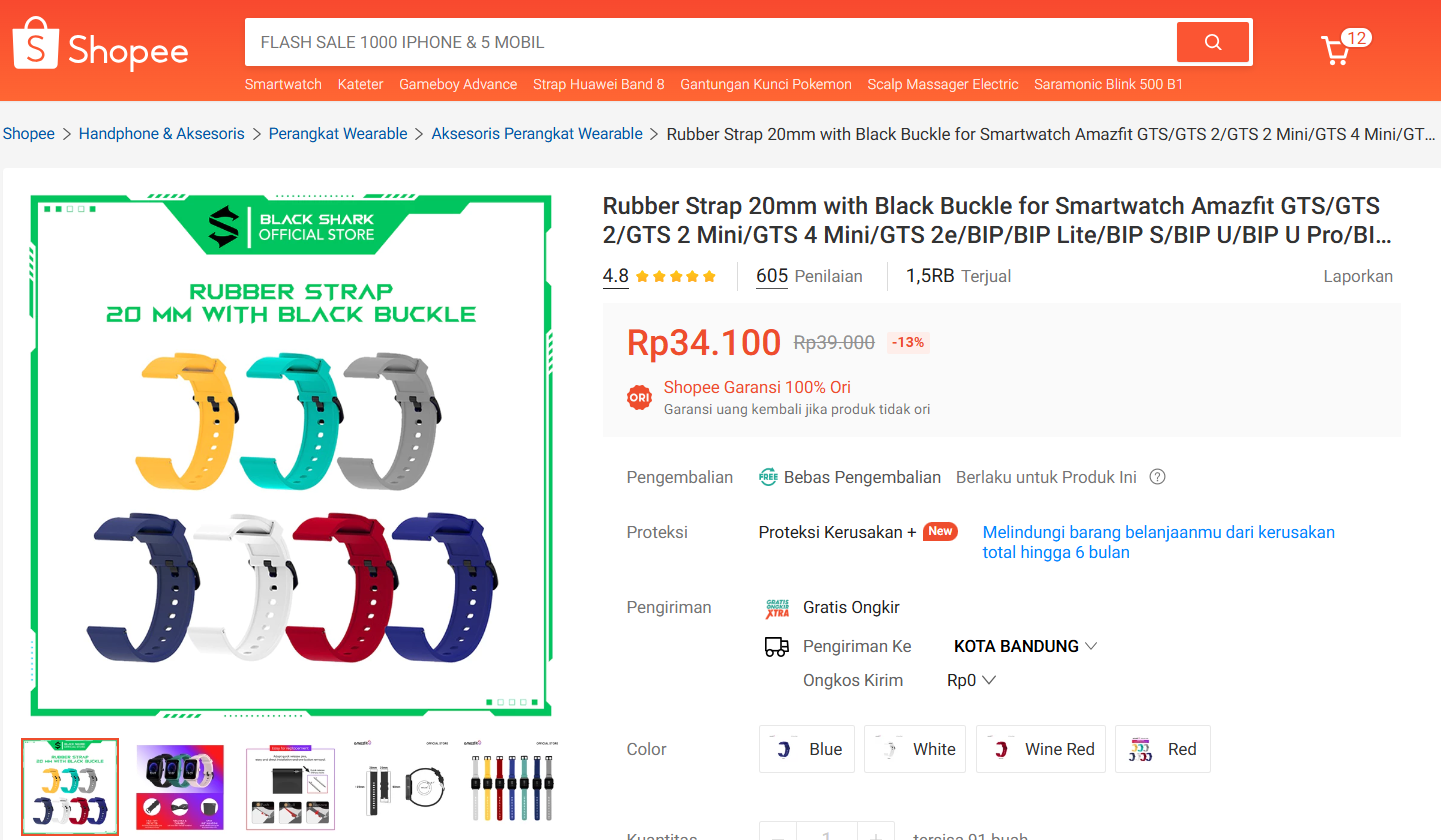

Selanjutnya, penulis mengambil data ulasan dari produk tersebut menggunakan metode *Web Scrapping* dengan ekstensi chrome *Data Miner*

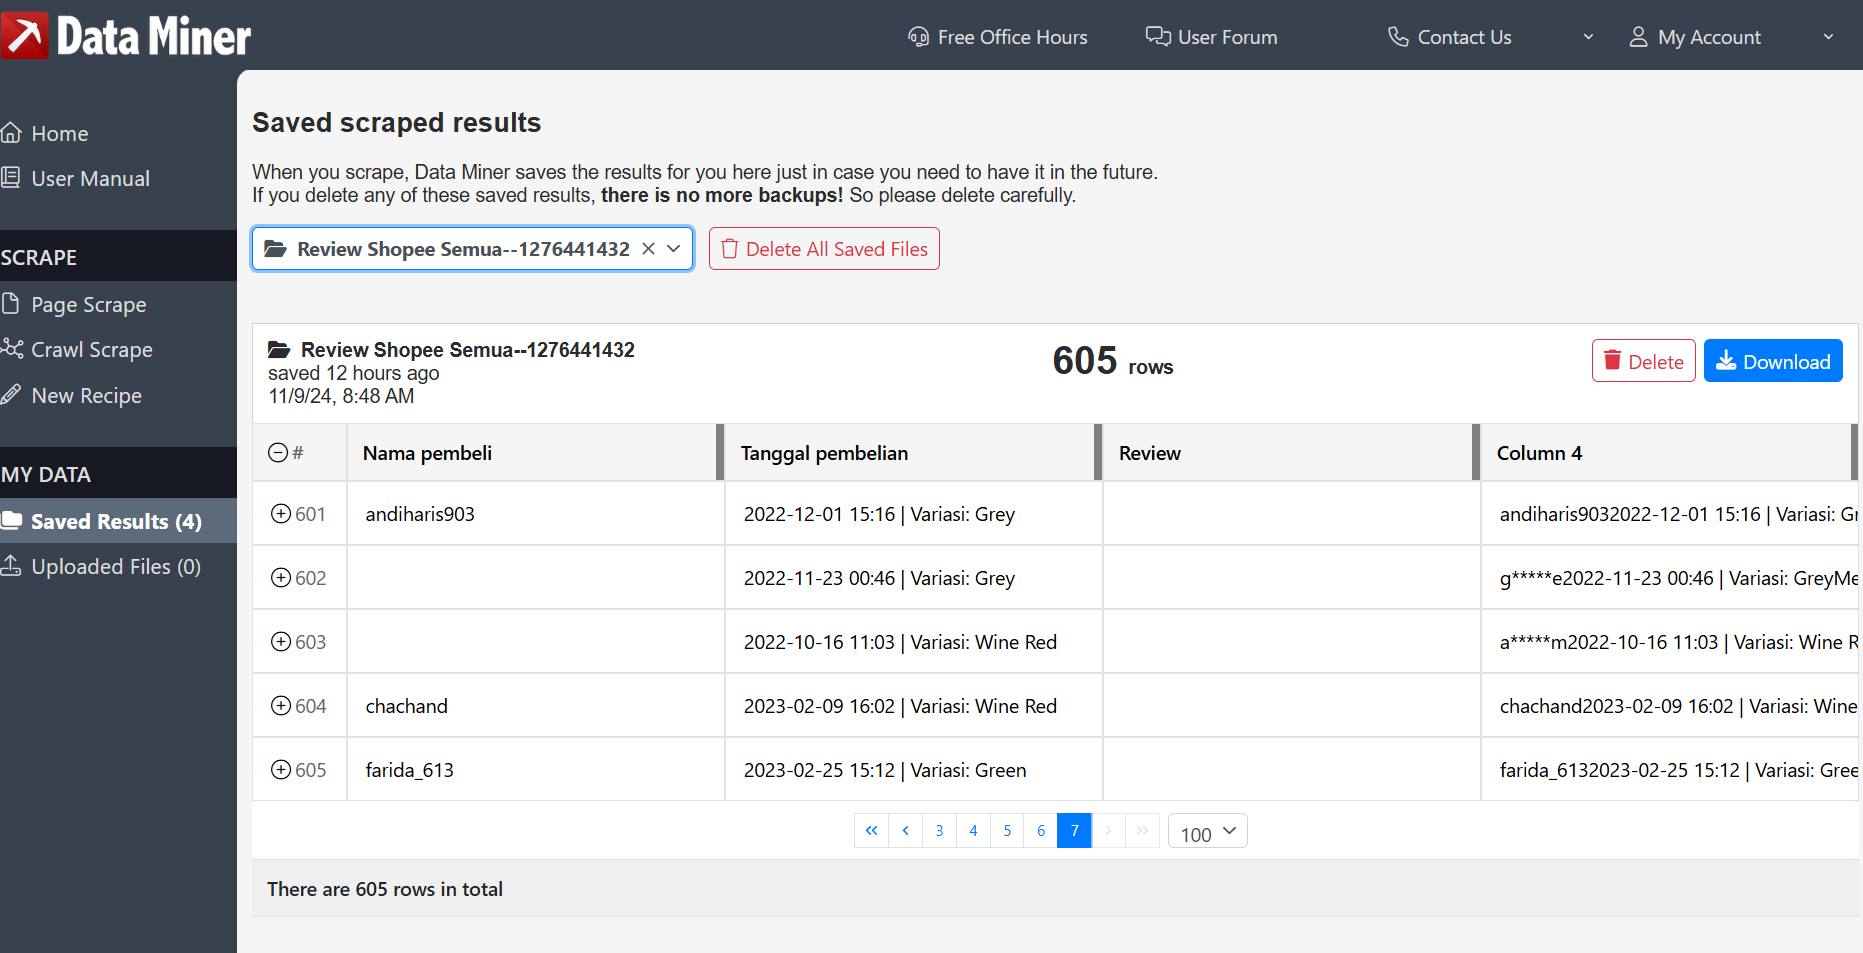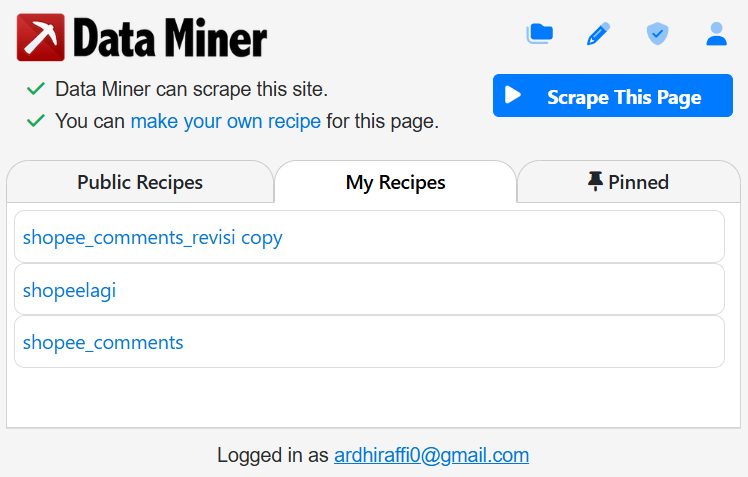

Penulis hanya menscrapping bagian Review dan Ratings yang akan digunakan sebagai kelas Input(Review) dan Target(Ratings)

Setelah melakukan *Web Scrapping*, penulis mulai masuk ke tahap pemrograman yang tahap-tahapnya sebagai berikut :

1. Pra Pemrosesan (Cleaning, Text Preprocessing, Normalization, Tokenization) :

  Tahap ini melibatkan pembersihan data mentah untuk menghapus elemen-elemen yang tidak relevan, normalisasi format teks, dan tokenisasi kata atau frasa untuk mengubah teks menjadi representasi numerik yang dapat diproses oleh model dan dapat dianalisis lebih mendalam.

2. Pemodelan :

  Pada tahap ini, data yang telah diproses akan digunakan untuk melatih dan menguji model menggunakan pre-trained model IndoBERT. Model IndoBERT ini adalah versi bahasa Indonesia dari BERT (Bidirectional Encoder Representations from Transformers), yang sudah dilatih dengan teks bahasa Indonesia dan dapat digunakan untuk memahami konteks bahasa Indonesia secara lebih baik. Dapat ditemukan pada link berikut : https://huggingface.co/indolem/indobert-base-uncased.
  
3. Evaluasi dan Analisis Hasil :

  Pada tahap ini, penulis menganalisis hasil sentimen yang dihasilkan oleh model. Beberapa langkah evaluasi dan analisis yang dilakukan meliputi:

    Visualisasi Sentimen: Menampilkan distribusi sentimen (positif, negatif, netral) dalam bentuk grafik untuk memberikan gambaran tentang bagaimana konsumen merespon produk tersebut.

    Analisis Tematik: Mengidentifikasi tema-tema utama yang sering muncul dalam ulasan positif atau negatif. Misalnya, apakah fitur tertentu dari produk (seperti kenyamanan strap atau ketahanan baterai) sering disebutkan dalam ulasan positif atau negatif?

    Insight: Menarik kesimpulan dari hasil analisis sentimen mengenai kekuatan dan kelemahan produk berdasarkan umpan balik pengguna.

# Tahap Pemrograman

1. Pra Pemrosesan

In [1]:
# Import libraries yang digunakan

import pandas as pd
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from transformers import TFBertForSequenceClassification, BertTokenizer, pipeline
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from textblob import TextBlob  # Import TextBlob

In [2]:
# Download VADER untuk analisis sentimen
nltk.download('vader_lexicon')

# Load pretrained sentiment analysis pipeline from HuggingFace using IndoBERT for Indonesian
sentiment_analyzer = pipeline("sentiment-analysis", model="indolem/indobert-base-uncased")

# Initialize VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

In [3]:
# Input Dataset dan Eksplorasi Data (EDA)

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset_Shopee_Review_Clean.csv')
df.info()
df = pd.DataFrame(df)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Nama Berbintang      154 non-null    object
 1   Waktu                605 non-null    object
 2   review               555 non-null    object
 3   Nama tak Berbintang  451 non-null    object
 4   ratings              605 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 23.8+ KB


,Nama Berbintang,Waktu,review,Nama tak Berbintang,ratings
0,NaN,2023-07-09 10:19 | Variasi: Yellow,Fitur Terbaik: pas buat amazfit bip,wahyu88x,5
1,a*****u,2023-07-10 20:30 | Variasi: Dark Blue,Sepadan dengan Harga: yaFitur Terbaik: yaPesan...,NaN,5
2,NaN,2023-05-08 14:10 | Variasi: Grey,"Sepadan dengan Harga: sesuai dgn harga, worth it",nonasifqa,5
3,NaN,2022-09-17 11:10 | Variasi: Grey,Fitur Terbaik: Best strap,artanoviabm,5
4,NaN,2023-03-18 17:28 | Variasi: Dark Blue,Sepadan dengan Harga: yes,novitalia26,5


In [4]:
# Cleaning Kolom

# df = df[["Column 4", "ratings"]]

df = df.drop(columns=['Nama Berbintang', 'Waktu', 'Nama tak Berbintang'])

df = df[df['review'].notnull()]
df = df.rename(columns={'review': 'reviews'})

In [5]:
df = df[~df['reviews'].isin(['Membantu?', 'Membantu?Laporkan Penyalahgunaan','respon penjual:'])]

In [6]:
df = df[~df['reviews'].str.contains('respon penjual:', na=False)]

In [7]:
df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107 entries, 0 to 275
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  107 non-null    object
 1   ratings  107 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.5+ KB


In [10]:
# Normalisasi Baris Rating

def minus_one(num):
    return num - 1  # Mengurangi nilai rating sebesar 1, sehingga 1-1=0, 5-1=4

df['ratings'] = df['ratings'].apply(minus_one)

In [11]:
# Data Splitting

X_train, X_test, y_train, y_test = train_test_split(df['reviews'], df['ratings'], test_size=0.2, random_state=42)

# 2. Pemodelan

In [12]:
# Inisiasi Pre Trained Model dan Tokenisasi

model_name = 'indolem/indobert-base-uncased'
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=5, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(model_name)

# from transformers import AutoTokenizer, AutoModel
# tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
# model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# 3. Analisis dan Kesimpulan

In [17]:
# Analisis Sentimen dengan Hugging Face dan VADER

def perform_sentiment_analysis(text_data):
    results = []

    for text in text_data:
        # 1. Using Hugging Face model (IndoBERT for Indonesian sentiment classification)
        huggingface_result = sentiment_analyzer(text)
        hf_label = huggingface_result[0]['label']
        hf_score = huggingface_result[0]['score']

        # 2. Using VADER for sentiment intensity (positive/negative score)
        vader_scores = sia.polarity_scores(text)
        vader_label = "Positive" if vader_scores['compound'] > 0 else "Negative" if vader_scores['compound'] < 0 else "Neutral"

        # 3. Using TextBlob for subjectivity and polarity (more granular analysis)
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity

        # Combining all results for detailed analysis
        analysis = {
            "text": text,
            "huggingface_label": hf_label,
            "huggingface_score": hf_score,
            "vader_label": vader_label,
            "vader_scores": vader_scores,
            "textblob_polarity": polarity,
            "textblob_subjectivity": subjectivity
        }
        results.append(analysis)

    return results

# Perform analysis on the text data
analysis_results = perform_sentiment_analysis(df['reviews'])

# Create a new DataFrame for the results
results_df = pd.DataFrame(analysis_results)

# Show the DataFrame with sentiment analysis results
print(results_df)

                                                  text huggingface_label  \
0                  Fitur Terbaik: pas buat amazfit bip           LABEL_1   
1    Sepadan dengan Harga: yaFitur Terbaik: yaPesan...           LABEL_0   
2     Sepadan dengan Harga: sesuai dgn harga, worth it           LABEL_0   
3                            Fitur Terbaik: Best strap           LABEL_1   
4                            Sepadan dengan Harga: yes           LABEL_0   
..                                                 ...               ...   
102                     Fitur Terbaik: bahannya lentur           LABEL_0   
103                         Sepadan dengan Harga: good           LABEL_1   
104  Fitur Terbaik: recommendedSepadan dengan Harga...           LABEL_0   
105                                          Langganan           LABEL_0   
106                                          Langganan           LABEL_0   

     huggingface_score vader_label  \
0             0.522481     Neutral   
1          

<ipython-input-18-ac7a9f705854>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='huggingface_label', data=results_df, palette='viridis')


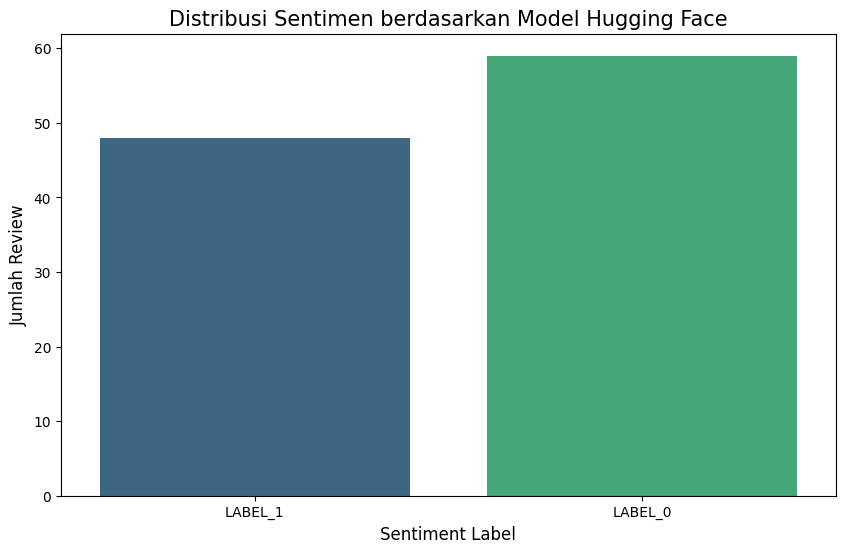

<ipython-input-18-ac7a9f705854>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='vader_label', data=results_df, palette='viridis')


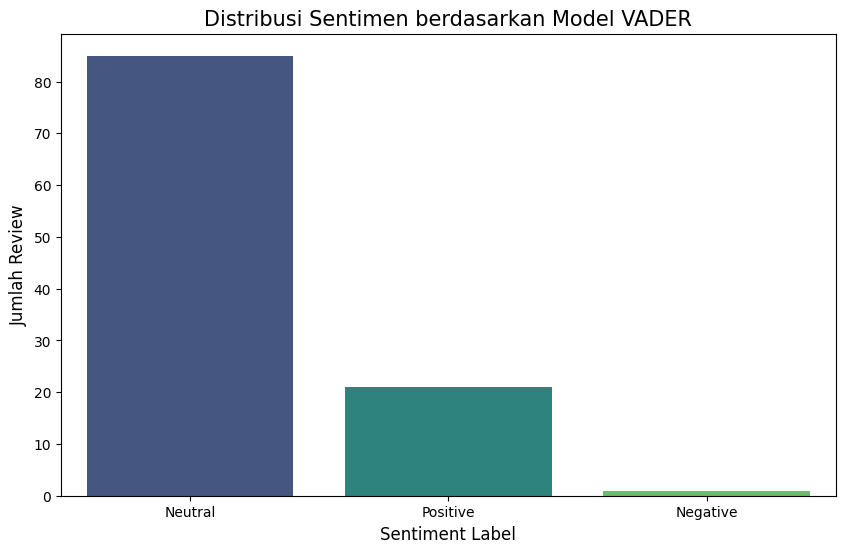

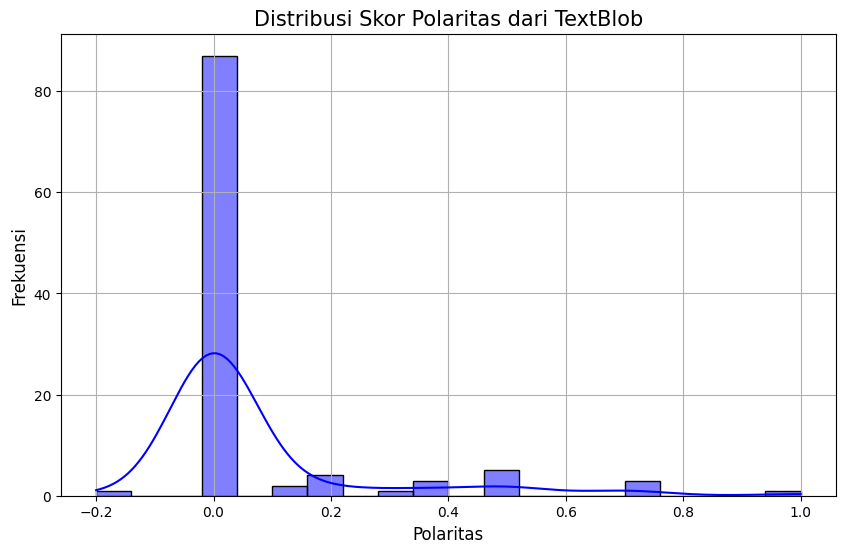

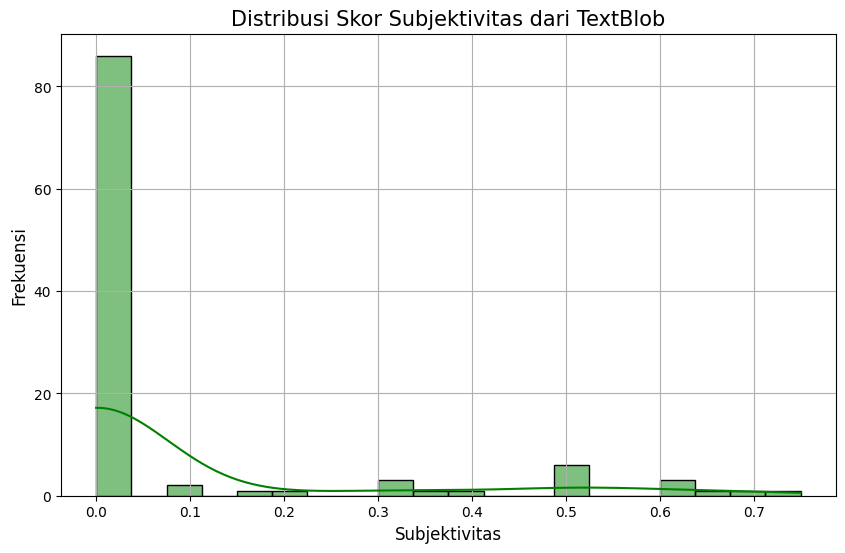

In [18]:
# Plot distribusi Hugging Face labels
plt.figure(figsize=(10, 6))
sns.countplot(x='huggingface_label', data=results_df, palette='viridis')
plt.title('Distribusi Sentimen berdasarkan Model Hugging Face', fontsize=15)
plt.xlabel('Sentiment Label', fontsize=12)
plt.ylabel('Jumlah Review', fontsize=12)
plt.show()

# Plot distribusi VADER labels
plt.figure(figsize=(10, 6))
sns.countplot(x='vader_label', data=results_df, palette='viridis')
plt.title('Distribusi Sentimen berdasarkan Model VADER', fontsize=15)
plt.xlabel('Sentiment Label', fontsize=12)
plt.ylabel('Jumlah Review', fontsize=12)
plt.show()

# Plot distribusi TextBlob polarity
plt.figure(figsize=(10, 6))
sns.histplot(results_df['textblob_polarity'], kde=True, color='blue', bins=20)
plt.title('Distribusi Skor Polaritas dari TextBlob', fontsize=15)
plt.xlabel('Polaritas', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.grid(True)
plt.show()

# Plot distribusi TextBlob subjectivity
plt.figure(figsize=(10, 6))
sns.histplot(results_df['textblob_subjectivity'], kde=True, color='green', bins=20)
plt.title('Distribusi Skor Subjektivitas dari TextBlob', fontsize=15)
plt.xlabel('Subjektivitas', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.grid(True)
plt.show()

In [19]:
# # Hitung distribusi label sebenarnya dan prediksi
# true_counts = np.bincount(y_test, minlength=5)
# predicted_counts = np.bincount(predicted_classes, minlength=5)

# # Plot grafik batang
# labels = [1, 2, 3, 4, 5]  # Rating dari 1 sampai 5
# x = np.arange(len(labels))  # Lokasi x untuk kelompok

# width = 0.35  # Lebar batang

# fig, ax = plt.subplots(figsize=(10, 6))
# rects1 = ax.bar(x - width/2, true_counts, width, label='True Labels')
# rects2 = ax.bar(x + width/2, predicted_counts, width, label='Predicted Labels')

# # Tambahkan beberapa fitur ke plot
# ax.set_xlabel('Ratings')
# ax.set_ylabel('Count')
# ax.set_title('Comparison of True and Predicted Ratings')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# # Menampilkan nilai di atas batang
# def autolabel(rects):
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate(f'{int(height)}',
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # Offset text posisi
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# autolabel(rects1)
# autolabel(rects2)

# plt.tight_layout()
# plt.show()


## Analisis

### Analisis 1: Distribusi Sentimen
Hugging Face Label (LABEL_0 vs LABEL_1):

Dari data, kita melihat bahwa sebagian besar ulasan memiliki label LABEL_0, yang umumnya menandakan sentimen netral atau negatif. Hanya beberapa yang diberi label LABEL_1, yang menunjukkan sentimen positif.

VADER Sentiment:

Mayoritas label dari model VADER adalah Neutral, dengan beberapa entri yang diberi label Positive. Tidak ada yang diberi label Negative, yang menunjukkan bahwa banyak teks yang memiliki sentimen netral dalam analisis ini.

TextBlob Polaritas:

Polaritas sebagian besar teks tampaknya berada pada nilai 0 (netral), meskipun beberapa entri memiliki polaritas yang sedikit lebih tinggi, menunjukkan kecenderungan sedikit positif atau negatif.

### Analisis 2: Perbandingan Antar Model
Hugging Face vs. VADER:

Secara umum, VADER cenderung memberikan lebih banyak label Neutral dibandingkan dengan Hugging Face yang lebih sering menggunakan label LABEL_0.
Model-model ini menunjukkan sedikit ketidaksesuaian dalam hal label sentimen. Sebagai contoh, ada entri dengan skor netral pada VADER tetapi dengan label negatif pada Hugging Face, yang menunjukkan bahwa dua model ini mungkin menggunakan kriteria berbeda untuk klasifikasi.

Hugging Face vs. TextBlob:

TextBlob menghasilkan polaritas yang lebih terperinci, yang memberikan wawasan lebih dalam dibandingkan dengan label sederhana dari Hugging Face. Skor polaritas yang lebih tinggi dari TextBlob biasanya berhubungan dengan label yang lebih positif, sementara nilai yang lebih rendah berhubungan dengan label lebih negatif atau netral.

### Analisis 3: Hubungan antara Skor dan Label

Hugging Face Score: Skor ini cenderung lebih tinggi untuk teks yang lebih positif, meskipun banyak ulasan memiliki skor mendekati 0.5, yang menandakan ketidakpastian atau keseimbangan antara sentimen positif dan negatif.

VADER Scores: Skor compound pada VADER sering kali menunjukkan nilai yang mendekati netral, yang konsisten dengan dominasi label Neutral. Ini menunjukkan bahwa teks yang dianalisis lebih sering bersifat netral, dengan sedikit sentimen ekstrem.

TextBlob Polarity: Teks dengan polaritas lebih positif cenderung memiliki skor di kisaran positif pada TextBlob, dan ini sering kali berhubungan dengan label yang lebih positif pada VADER dan Hugging Face.


## Kesimpulan

Mayoritas ulasan menunjukkan sentimen netral di semua model, baik itu melalui Hugging Face, VADER, atau TextBlob.
Hugging Face memberikan label yang lebih sering berkisar pada LABEL_0, sedangkan VADER mengklasifikasikan banyak teks sebagai Neutral.
Sentimen Positif:

Meskipun jarang, teks dengan sentimen positif pada VADER dan TextBlob cenderung memiliki polaritas lebih tinggi, dan ini biasanya sesuai dengan label LABEL_1 dari Hugging Face.
Ketidaksesuaian Model:

Ada sedikit ketidaksesuaian dalam klasifikasi antar model, menunjukkan bahwa masing-masing model memiliki cara yang berbeda dalam menilai sentimen.

VADER lebih cenderung memberikan label Neutral dibandingkan dengan Hugging Face, yang dapat disebabkan oleh cara masing-masing model menangani data yang lebih ambigu.